In [10]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
# mplhep is a library for tweaking the appearance of plots 
# in the matplotlib library. It can be installed by typing
# "pip install mplhep" into a terminal.  If you have trouble
# installing mplhep, you can comment out the next two lines
# which will then use the default matplotlib settings
import mplhep as hep
hep.style.use("CMS")

In [14]:
#define a function for plotting the kinematics

def plot_kinematics(df):

    # set the aspect ratio, axis label, and axis limits
    plt.gca().set_aspect(1)
    plt.xlabel("$P_x$ [GeV]")
    plt.ylabel("$P_z$ [GeV]")
    plt.xlim(14, -14) # This has the x axis be positive on the left side, as is convention for bird's eye view
    plt.ylim(-14, 14)

    
    # calculate the x and z components of the central momentum settings of the HMS and SHMS listed in the dataframe.  
    Pz1=df.eval(f"p_pi*cos(th_pi)")
    Px1=df.eval(f"p_pi*sin(th_pi)")
    Pz2=df.eval(f"E_ep*cos(th_ep)")
    Px2=df.eval(f"-E_ep*sin(th_ep)")
    
    # now plot these values.  The length of the lines represent the magnitude of the central moemntum in the detector.   
    for i in range(len(df)):
        # We draw the pair of lines as a V, starting from the SHMS, then going to the origin, then to the HMS
        plt.plot([Px1[i],0,Px2[i]], [Pz1[i],0,Pz2[i]], label=f'$Q^2$={df.Q2[i]:.2} GeV$^2/c^2$', lw=2)
    
    # now show the beamline 
    plt.plot([0,0], [-df.Ee[0], 0], ls='-', color='k',lw=2)

    # now show the ranges of values that can be set for the SHMS and HMS central momentum vectors.
    # these will be shown as filled polygons
    from matplotlib.patches import Polygon
    # theta min, theta max, pmin, pmax of central kinematics, in the HMS and SHMS
    for ranges in ((-10.5, -90, 0.4, 7.3), (5.5,25, 2.5,11)):
        points= np.array([np.concatenate(([ranges[2]*f(ranges[0]*np.pi/180), ranges[3]*f(ranges[0]*np.pi/180)], 
                           ranges[3]*f(np.linspace(ranges[0]*np.pi/180, ranges[1]*np.pi/180, 20)),
                           [ranges[3]*f(ranges[1]*np.pi/180), ranges[2]*f(ranges[1]*np.pi/180)], 
                           ranges[2]*f(np.linspace(ranges[1]*np.pi/180, ranges[0]*np.pi/180, 20))))\
                        for f in (np.sin, np.cos)])
        points=np.transpose(points)
        plt.gca().add_patch(Polygon(points, color='0.8', zorder=-1))

    # now show as dashed lines the limits of acceptance when the HMS and SHMS central kinematics are at their extreme values
    for ranges in ((-10.5+.032*180/np.pi, -90-.032*180/np.pi, 0.4*.9, 7.3*1.1),\
                   (5.5-0.018*180/np.pi,25+0.018*180/np.pi, 2.5*.85,11*1.25)):
        points= np.array([np.concatenate(([ranges[2]*f(ranges[0]*np.pi/180), ranges[3]*f(ranges[0]*np.pi/180)], 
                           ranges[3]*f(np.linspace(ranges[0]*np.pi/180, ranges[1]*np.pi/180, 20)),
                           [ranges[3]*f(ranges[1]*np.pi/180), ranges[2]*f(ranges[1]*np.pi/180)], 
                           ranges[2]*f(np.linspace(ranges[1]*np.pi/180, ranges[0]*np.pi/180, 20))))\
                        for f in (np.sin, np.cos)])
        plt.gca().plot(*points, color='0.8', zorder=-1, ls='--')

    # label the two spectrometers.
    plt.text(10, 5, "SHMS, $\\pi^+$")
    plt.text(-4, 8, "HMS, $e^-$")
    
    # finally, create a legend, showing the labels for each of the kinematics
    plt.legend()
    

In [ ]:
# now create a dataframe containing the kinematics of the PionCT experiment
df=pd.DataFrame()


Ee=10.7                           # energy of the beam electron [GeV]
min_theta_pi=7.5*np.pi/180        # minimum allowed angle for the SHMS (which will be measuring pions in this experiment)
m_p=0.93827208943                 # mass of a proton in GeV
m_pi=0.1357039                    # mass of a pion in GeV
df['Q2']=[5.0,6.5,8.5,7.5]        # These are the values of Q^2 [in GeV^2] for each of the four settings
df['t']=[-0.4,-0.4,-0.4,-0.4]     # four momentum transfered to the proton


# calculate the electron (HMS) momentum and energy constrained by:
# the Q^2 values we've decided upon above
# the Bjorken x variable, x=Q^2/(2*m*nu), is 0.5, 
# or as close to that as achievable without having the direction 
# of the virtual photon be less than 7.5 degrees (since we want the
# pion (SHMS) direction aligned with the virtual photon direction)

sth2=np.sin(min_theta_pi)**2
cth=np.cos(min_theta_pi)
xcalc=(sth2*Ee*df.Q2)/\
        (-m_p*df.Q2+m_p*cth*np.sqrt(df.Q2*(4*sth2*Ee**2+df.Q2)))
df['x']=0.5*(xcalc<0.5)+xcalc*(xcalc>=0.5)

#fill in the rest of the electron kinematics from the x and Q^2
df['Ee']=[Ee]*len(df)
df['E_ep']=df.eval(f'Ee-Q2/(2*{m_p}*x)')
df['th_ep']=df.eval('2*arcsin(sqrt(Q2/(4*Ee*E_ep)))')

# now determine the theta of the pion (SHMS) which should be aligned with the virtual photon.
df['th_pi']=df.eval('arctan2(E_ep*sin(th_ep), Ee-E_ep*cos(th_ep))')
# This is the virtual photon momentum
df['q']=df.eval("sqrt((E_ep*sin(th_ep))**2+(Ee-E_ep*cos(th_ep))**2)")
# and its energy
df['nu']=df.eval('Ee-E_ep')

# calculate the momentum of the pion such that the four momentum squared of the beam electron minus the scattered electron and the pion is equal to t
df['p_pi']=df.eval(f"1/(2*Q2)*(-q*{m_pi}**2+q*Q2+q*t+nu*sqrt({m_pi}**4+(Q2+t)**2-2*{m_pi}**2*(-Q2+t)))")

# k is the virtual photon momentum minus the pion momentum
df['k_pi']=df.eval('q-p_pi')

# now calculate both of the angles in degrees as well
df['thd_pi']=df.th_pi*180/np.pi
df['thd_ep']=df.th_ep*180/np.pi


# here are a few more variables we calculate
df['W']=df.eval(f"sqrt({m_p}**2+2*(Ee-E_ep)*{m_p}-Q2)")  
df['z']=df.eval(f"sqrt({m_pi}**2+p_pi**2)/(Ee-E_ep)")
df['y']=df.eval("(Ee-E_ep)/Ee")

df_kinematics=df

In [16]:
#now print the kinematics as a table
df_kinematics

,Q2,t,x,Ee,E_ep,th_ep,th_pi,q,nu,p_pi,k_pi,thd_pi,thd_ep,W,z,y
0,5.0,-0.4,0.500000,10.7,5.371055,0.296040,0.274575,5.779070,5.328945,5.110557,0.668513,15.731974,16.961841,2.424944,0.959357,0.498032
1,6.5,-0.4,0.500000,10.7,3.772372,0.404032,0.202278,7.381872,6.927628,6.715097,0.666775,11.589669,23.149315,2.716681,0.969519,0.647442
2,8.5,-0.4,0.520827,10.7,2.003055,0.640654,0.130900,9.172614,8.696945,8.514733,0.657882,7.500000,36.706796,2.949671,0.979173,0.812799
3,7.5,-0.4,0.500000,10.7,2.706583,0.514553,0.158306,8.449539,7.993417,7.783542,0.665997,9.070263,29.481690,2.894884,0.973892,0.747048


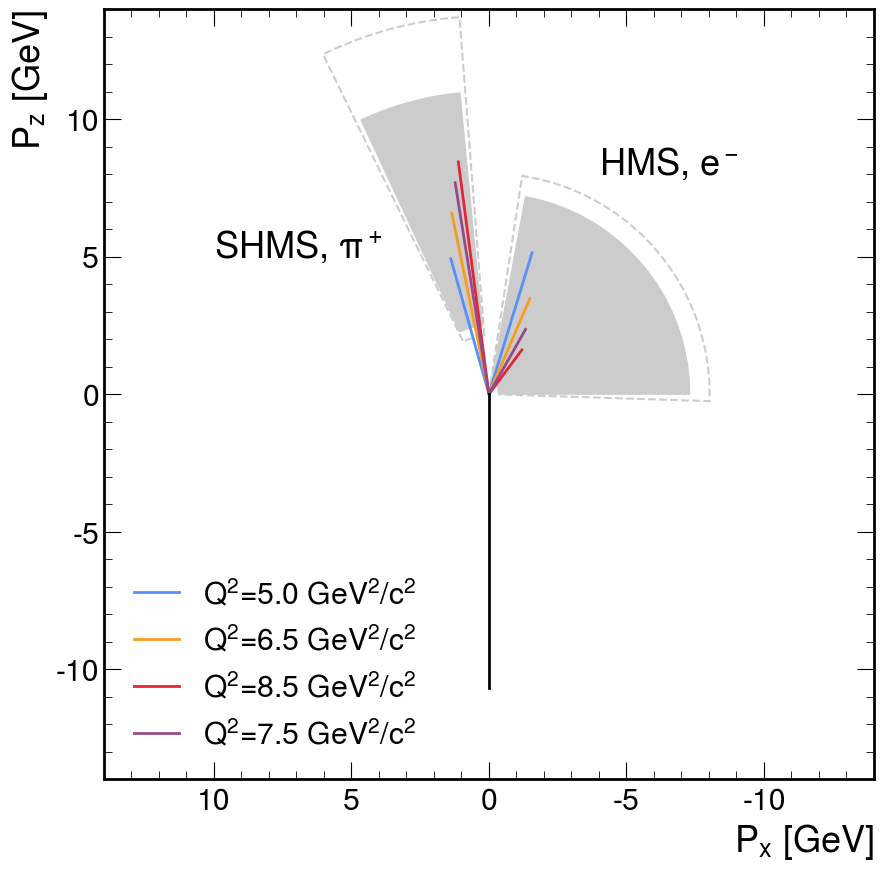

In [17]:
plot_kinematics(df_kinematics)